## Module's importation

In [97]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge, ElasticNetCV, ElasticNet
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from graphviz import Source
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import learning_curve,train_test_split, GridSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV,GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pydot
from PIL import Image
from IPython.display import Image as IPImage
from matplotlib.gridspec import GridSpec



## Load data

Duplicates in vendor_battery_id:
   vendor_battery_id  count
0   00130918000009C6      2
1   00130C0400000D96      2
2   00130C0A0000032A      2
3   00140C16000018BA      2
4   001501130000094B      2
5   0015070700000608      2
6   00150916000000B5      2
7   0015091600000C96      2
8   00150A1600000D3F      2
9   00150C0700000AED      2
10  00150C0900000478      2
11  0016061C000006BD      2


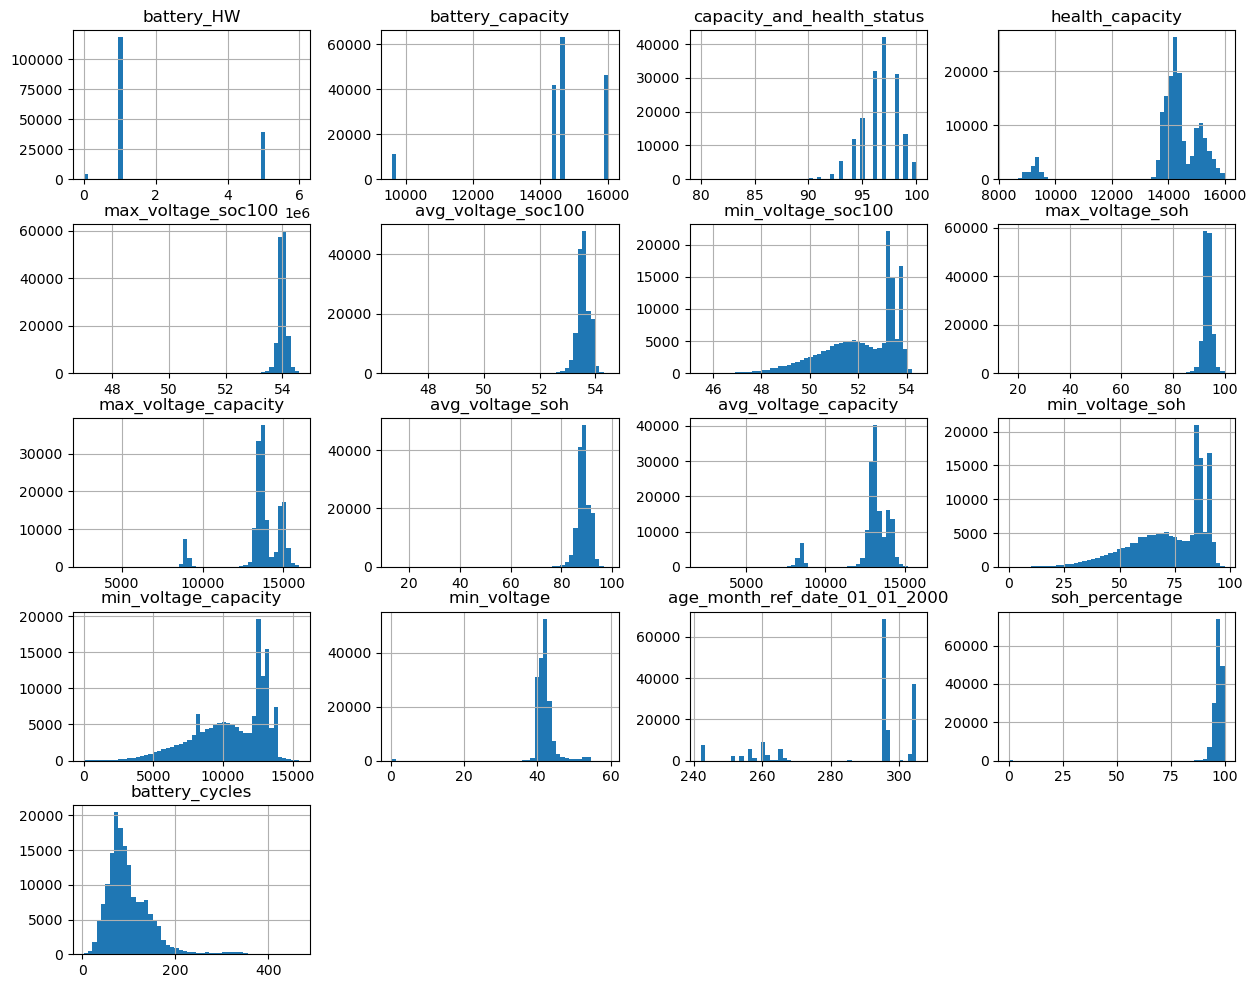

In [67]:

# Load the datasets
battery_features_df = pd.read_csv('Okai battery query output 2.csv')
raw_soh_battery_testing_df = pd.read_csv('SoH battery tests - Database.csv')

soh_battery_testing_df = raw_soh_battery_testing_df.copy()
soh_battery_testing_df = soh_battery_testing_df[soh_battery_testing_df['vendor'] != 'ninebot']


#delete blank before and after items in vendor_battery_id example: ' 1234 ' to '1234'
soh_battery_testing_df['vendor_battery_id'] = soh_battery_testing_df['vendor_battery_id'].str.strip()

#print(true_soh_df.info())
#print(true_soh_df.head())

#print(unlabeled_df.info())
#print(unlabeled_df.head())
# how many duplicates vendor_battery_id in the soh_battery_testing_df
# create a dataframe for unique duplicates in vendor_battery_id + the number of duplicates
duplicates_df = soh_battery_testing_df[soh_battery_testing_df.duplicated(subset='vendor_battery_id', keep=False)]
duplicates_count_df = duplicates_df.groupby('vendor_battery_id').size().reset_index(name='count')
duplicates_count_df = duplicates_count_df.sort_values(by='count', ascending=False)
print("Duplicates in vendor_battery_id:")
print(duplicates_count_df)


#duplicates = soh_battery_testing_df['vendor_battery_id'].duplicated().sum()
#print(f"Number of duplicates in vendor_battery_id: {duplicates}")

# for duplicates, compute the mean of eload_capacity
soh_battery_testing_df = soh_battery_testing_df.groupby('vendor_battery_id').agg({
    'eload_capacity': 'mean',
    'date': 'first',  # will be the most recent date after sorting
    'vendor': 'first',
    'city_name': 'first',
    'capacity': 'first',
    'discharge_current': 'first'
}).reset_index()

soh_battery_testing_df['capacity'] = soh_battery_testing_df['capacity'].astype(int)

soh_battery_testing_df["eload_soh"] = soh_battery_testing_df["eload_capacity"] / soh_battery_testing_df["capacity"] * 100

battery_features_df.hist(bins=50, figsize=(15, 12))
plt.show()

## Pipeline

In [68]:
merged_df = pd.merge(battery_features_df, soh_battery_testing_df,  on='vendor_battery_id', how='left')
merged_df.drop(columns=['date','vendor'], inplace=True) 
merged_df.rename(columns={'city_name': 'market_name_eload',  'capacity': 'battery_capacity_test'}, inplace=True)

# Creating two dataset : labeled and unlabeled
unlabeled_df = merged_df.copy()
unlabeled_df = unlabeled_df[unlabeled_df['eload_capacity'].isna()]

labeled_df = merged_df.copy()
labeled_df = labeled_df[labeled_df['eload_capacity'].notna()]
labeled_merged_df = soh_battery_testing_df.copy()

# create a df to find the batteries that are in battery_features_df but not in labeled_merged_df
labeled_merged_df = labeled_merged_df[~labeled_merged_df['vendor_battery_id'].isin(labeled_df['vendor_battery_id'])]

# Check for batteries that were tested but not found in the query database
not_match_labeled_df = labeled_df.copy()
not_match_labeled_df = not_match_labeled_df[not_match_labeled_df['battery_cycles'].isna()]
labeled_df = labeled_df[labeled_df['battery_cycles'].notna()]
not_match_labeled_df = not_match_labeled_df[['vendor_battery_id', 'battery_capacity_test', 'market_name_eload', 'discharge_current']]


# Missmach capacities: check if battery_capacity is equal to battery_capcity_test
missmatch_capacities_df = labeled_df.copy()

# Filter out rows where battery_capacity is equal to battery_cycles
missmatch_capacities_df = missmatch_capacities_df[missmatch_capacities_df['battery_capacity'] != missmatch_capacities_df['battery_capacity_test']]
labeled_df = labeled_df[labeled_df['battery_capacity'] == labeled_df['battery_capacity_test']]

print("Number of unique batteries tested : ", len(soh_battery_testing_df))
print("Number of batteries tested but NOT FOUND in the query database: ", len(labeled_merged_df))
print("Number of batteries tested but IDs are not matching: ", len(missmatch_capacities_df))
print("\n")
print("Final number of batteries in the labeled dataset: ", len(labeled_df))


print("\n")
print("Batteries tested but not found in the query database:")
print(labeled_merged_df['vendor_battery_id'].unique())

print("\n")
print("Batteries tested but IDs are not matching:")
print(missmatch_capacities_df[['vendor_battery_id', 'market_name_eload','battery_capacity','battery_capacity_test']])



Number of unique batteries tested :  180
Number of batteries tested but NOT FOUND in the query database:  17
Number of batteries tested but IDs are not matching:  7


Final number of batteries in the labeled dataset:  156


Batteries tested but not found in the query database:
['00130C0A00000FCA' '0014051400001557' '0014061600000382'
 '0014070A000012C1' '0014071F000002CF' '0015031B00002152'
 '0015040900000264' '0015041C000003EB' '0015061200000731'
 '0015070700000101F' '0015070700000420' '0015070700000F18'
 '00150A1600000FDB' '00150A170000018A' '00150B0500000E42'
 '0016061C000006BD' '01170A0B0000003B']


Batteries tested but IDs are not matching:
       vendor_battery_id market_name_eload  battery_capacity  \
33294   0014080300000F88           Pheonix             14400   
35850   0014071700000114           Pheonix             14400   
42705   0014071F000005EA           Pheonix             14400   
91279   00150C0800000EE3           Pheonix             14400   
115487  0015030B00000106  

In [69]:
X=labeled_df.drop(columns=['eload_capacity'])
y=labeled_df['eload_capacity']

labeled_df['group'] = labeled_df['eload_soh'].astype(str) + '_' + labeled_df['battery_sku'].astype(str)
groups = labeled_df['group']

gss = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

# Perform the group-based split
for train_idx, test_idx in gss.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("\n")
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))



Training set size: 78
Test set size: 78


In [161]:
def enforce_dtypes_unlabeled_df(df):
    df = df.copy()
    df["battery_capacity"] = df["battery_capacity"].astype(int)
    df["age_day"] = df["age_day"].astype(int)
    df["actual_capacity"] = df["actual_capacity"].astype(int)
    df["capacity_and_health_status"] = df["capacity_and_health_status"].astype(int)
    df["is_broken"] = df["is_broken"].astype(bool)
    df["health_capacity"] = df["health_capacity"].astype(float)
    return df

def enforce_dtypes_true_soh_df(df):
    df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
    df["capacity"] = df["capacity"].astype(int)
    df["discharge_current"] = df["discharge_current"].str.replace(",", ".")
    df["discharge_current"] = df["discharge_current"].astype(float)
    df.drop(columns=["eload_soh_rounded"], inplace=True)
    df.drop(columns=["eload_soh"], inplace=True)
    df["eload_soh"] = round(df["eload_capacity"]/df["capacity"]*100, 2)
    return df

def enforce_dtypes(df):
    df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
    df["capacity"] = df["capacity"].astype(int)
    df["discharge_current"] = df["discharge_current"].str.replace(",", ".")
    df["discharge_current"] = df["discharge_current"].astype(float)
    df.drop(columns=["eload_soh_rounded"], inplace=True)
    df.drop(columns=["eload_soh"], inplace=True)
    df["eload_soh"] = round(df["eload_capacity"]/df["capacity"]*100, 2)
    return df

# Custom transformer for clustering categorical features
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=5):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    def fit(self, X, y=None):
        # Fit KMeans on the one-hot encoded categorical features
        self.kmeans.fit(X)
        return self

    def transform(self, X):
        # Transform the categorical features into cluster labels
        return self.kmeans.transform(X)
    
    def get_feature_names_out(self, input_features=None):
        # Generate feature names for the cluster labels
        return [f"cluster_{i}" for i in range(self.n_clusters)]


num_pipelines = make_pipeline(
    KNNImputer(),
    StandardScaler()  # Standardize numerical features
    )

cat_pipelines = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False)
    )


cluster_pipelines = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False),
    ClusterSimilarity()  # No need to specify n_clusters here
)

log_transformer = FunctionTransformer(np.log1p, validate=True, feature_names_out='one-to-one')

log_pipeline = make_pipeline(
    KNNImputer(),
    log_transformer,
    StandardScaler()
)

interaction_pipeline = Pipeline([
    ('poly', PolynomialFeatures(
        degree=2,
        interaction_only=True,  # Only interactions, no x^2 terms
        include_bias=False      # Don't include constant term
    ))
])

cat_interaction_pipeline = Pipeline([
    ('cat_base', cat_pipelines),  # First apply your existing categorical pipeline
    ('cat_inte', PolynomialFeatures(
        degree=2,
        interaction_only=True,
        include_bias=False
    ))
])

""" preprocessing = ColumnTransformer(
    transformers=[
        ("num", num_pipelines, ["battery_capacity","age_day","distance_km","ctsd","idle_drainage_24h","is_broken", "actual_capacity_mAh", "voltage_soc100", "health_capacity"]),
        ("cat", cat_pipelines, ["battery_sku","market_name"]),
        ("cluster", cluster_pipelines, ["battery_sku", "market_name"]),
        ("log", log_transformer, ["ctsd"])
    ]
) """

"""
preprocessing = ColumnTransformer(
    transformers=[
        ("num", num_pipelines, ["battery_capacity","capacity_and_health_status", "health_capacity", "voltage_soc100","voltage_soh","voltage_capacity","age_day","is_broken"]),
        ("cat", cat_pipelines, ["battery_sku"])
    ]
)
"""
"""
preprocessing = ColumnTransformer(
    transformers=[("num", num_pipelines,
        ["battery_capacity", "age_month_ref_date_01_01_2000", "capacity_and_health_status",
           "min_health_capacity", "voltage_soc100", "min_voltage_soc100",
           "voltage_soh", "min_voltage_soh", "voltage_capacity",
           "min_voltage_capacity", "battery_cycles"]),
        ("cat", cat_pipelines,
        ["battery_sku", "market_name"]),
        ("log", log_pipeline, 
        ["voltage_soc100", "min_voltage_soc100", "voltage_soh",
            "min_voltage_soh", "voltage_capacity", "min_voltage_capacity"]),
            ]
)
"""
"""

preprocessing = ColumnTransformer(
    transformers=[("num", num_pipelines,
        ["battery_capacity", "age_month_ref_date_01_01_2000",
           "health_capacity", "max_voltage_capacity", "avg_voltage_capacity",
           "min_voltage_capacity", "battery_cycles"]),
        ("cat", cat_pipelines,
        ["battery_sku", "market_name", "battery_HW", "is_broken","is_QB_92"]),
        ("log", log_pipeline, 
        ["max_voltage_capacity", "avg_voltage_capacity",
           "min_voltage_capacity", "battery_cycles",  "age_month_ref_date_01_01_2000"]),
            ]
)
"""

preprocessing = ColumnTransformer(
    transformers=[
        ("num", num_pipelines, [
            "battery_capacity", "age_month_ref_date_01_01_2000",
            "health_capacity", "max_voltage_capacity", "avg_voltage_capacity",
            "min_voltage_capacity", "battery_cycles"
        ]),
        ("cat", cat_pipelines, [
            "battery_sku", "battery_HW", "is_broken", "is_QB_92"
        ]),
        ("log", log_pipeline, [
            "max_voltage_capacity", "avg_voltage_capacity",
            "min_voltage_capacity", "battery_cycles", "age_month_ref_date_01_01_2000"
        ]),
        ("cat_interactions", cat_interaction_pipeline, [
            "battery_sku", "battery_HW"
        ])
    ]
)


# Create a complete preprocessing pipeline with interactions
complete_preprocessing = Pipeline([
    ('base_preprocessing', preprocessing),
    ('interactions', interaction_pipeline)
])



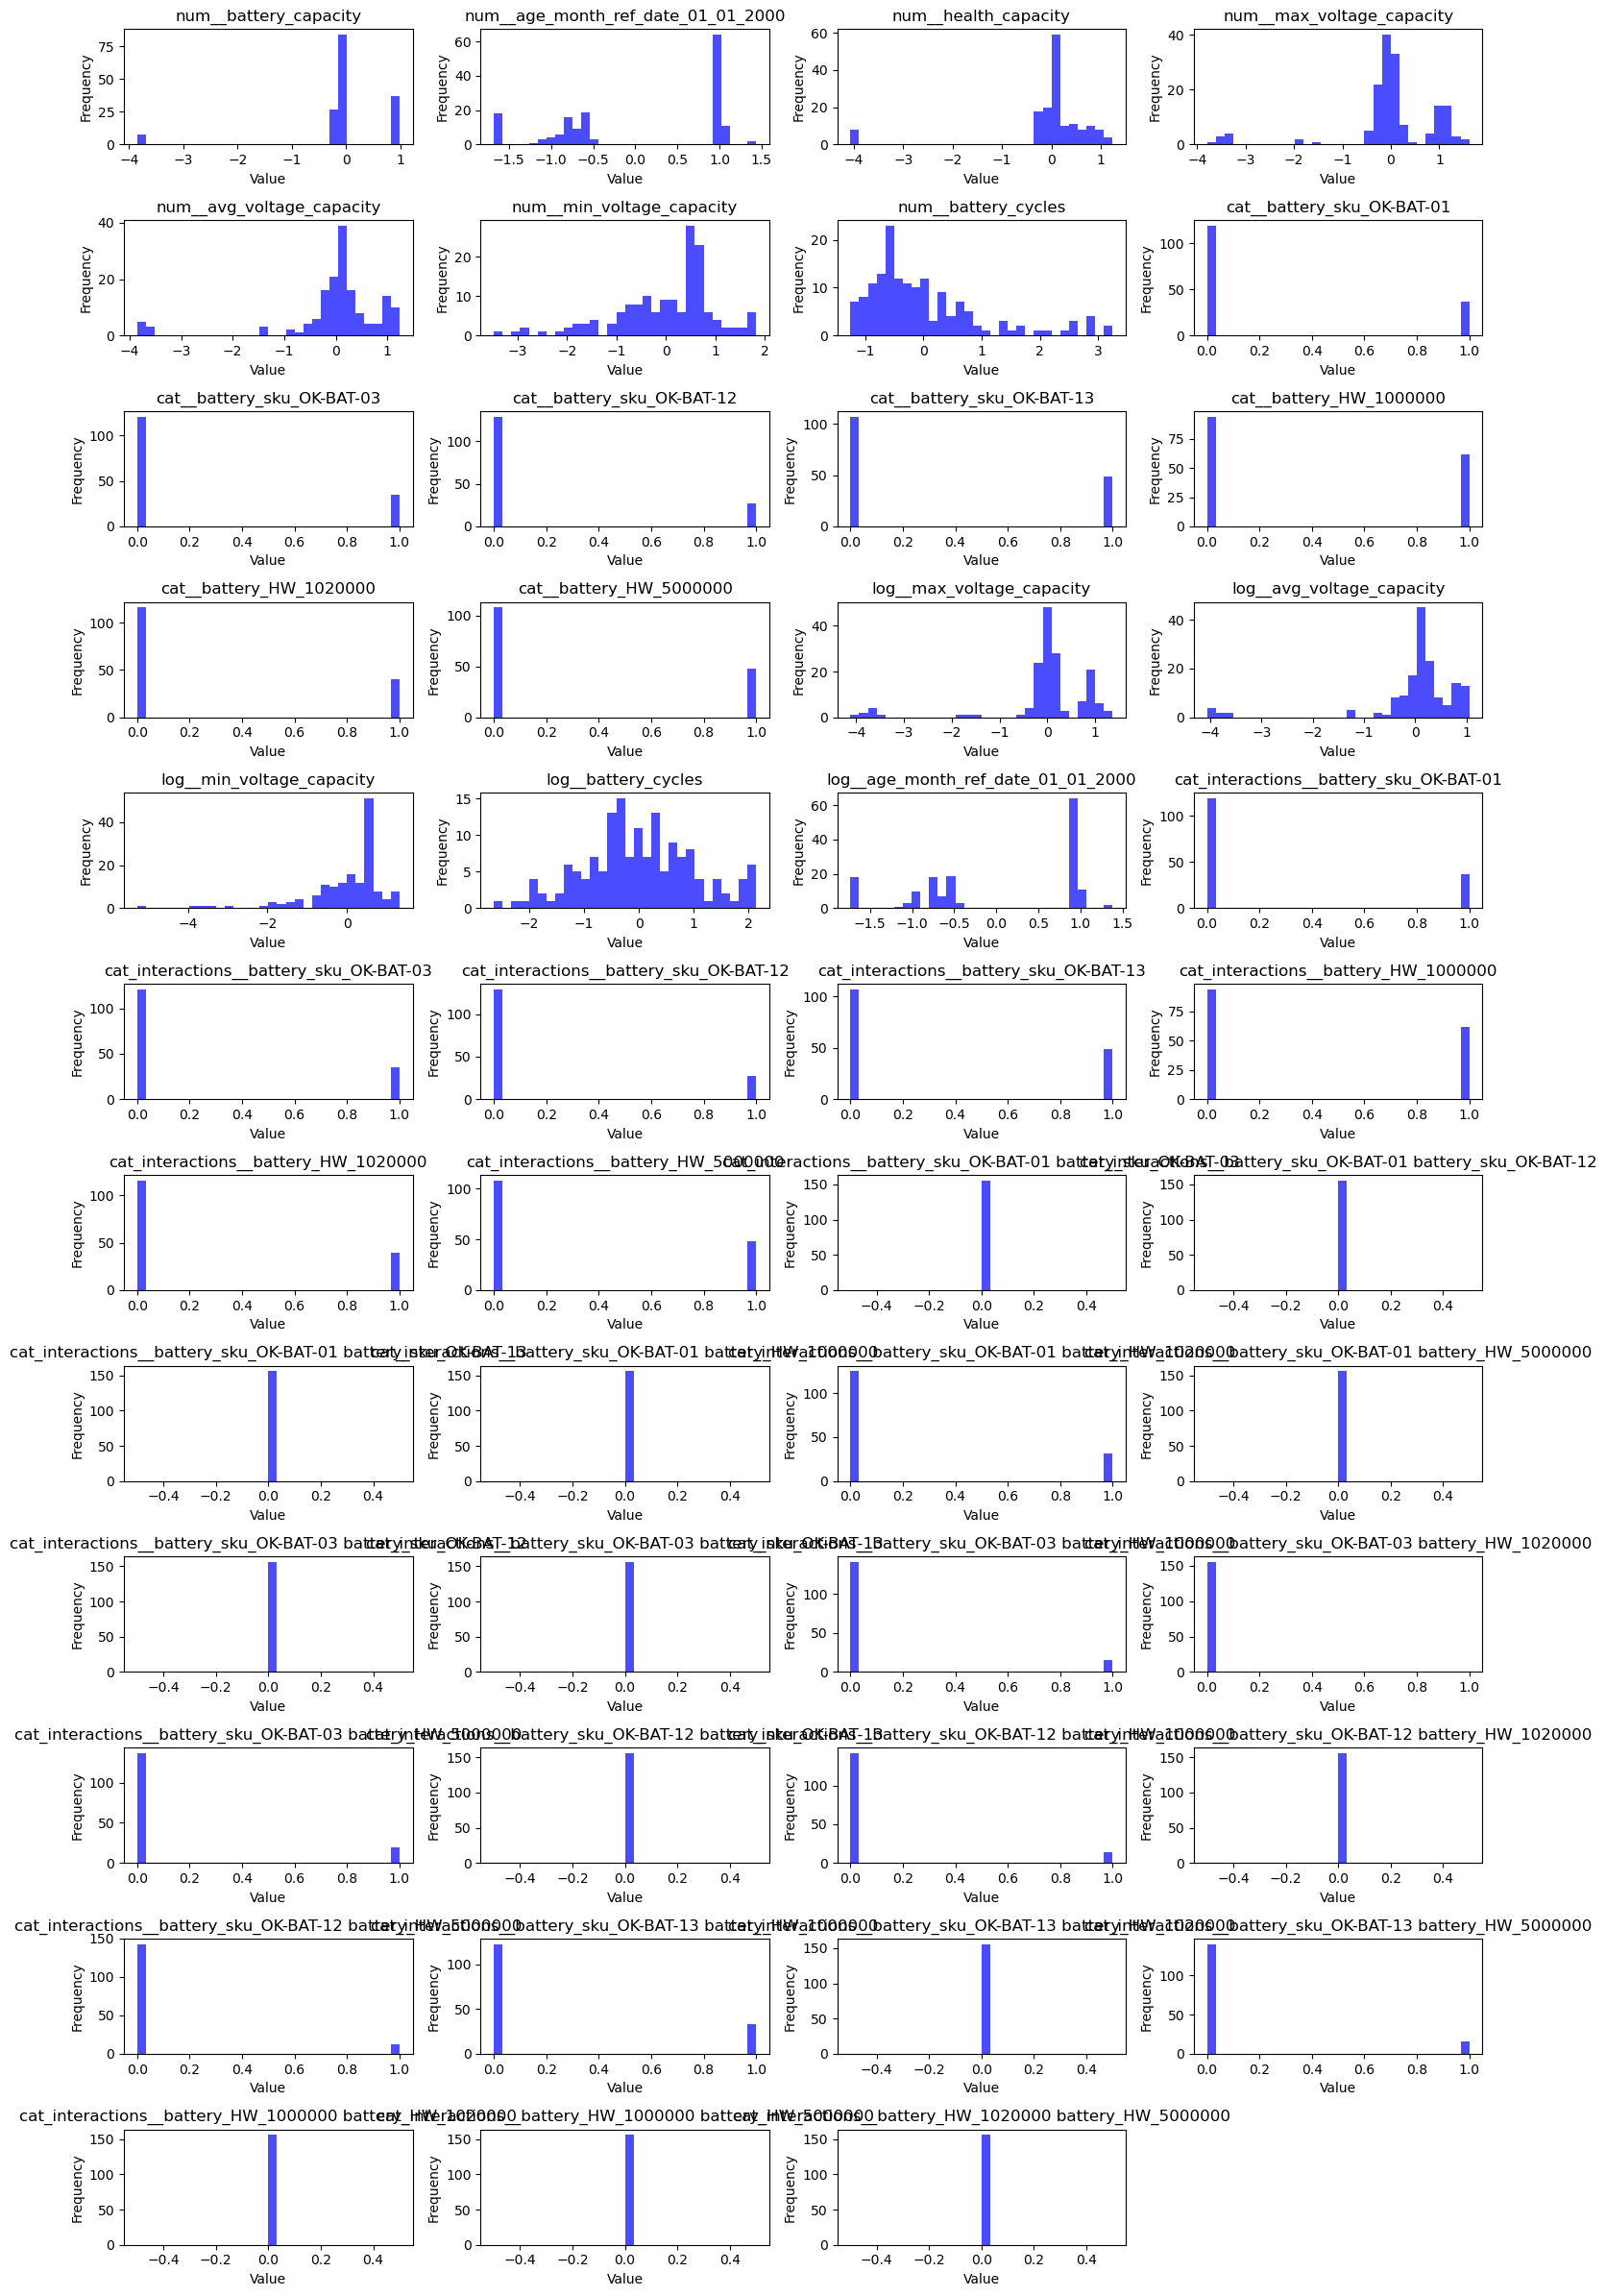

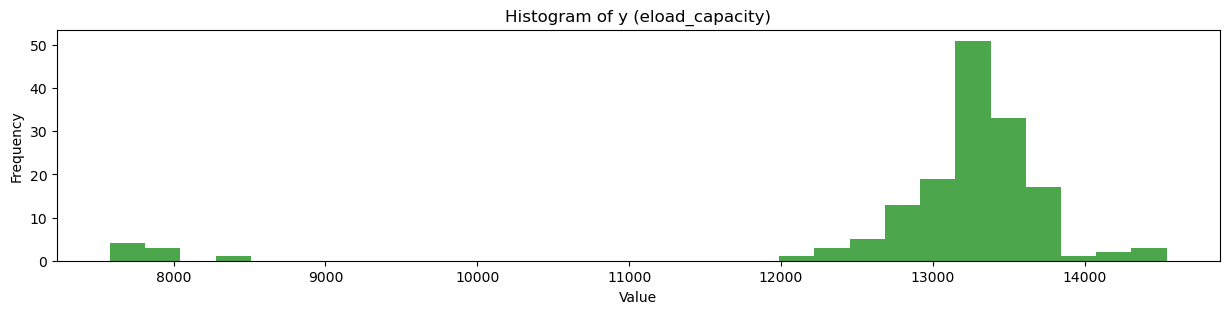

In [137]:
# Apply the preprocessing to X
X_preprocessed = preprocessing.fit_transform(X)

# Get the feature names after preprocessing
feature_names = preprocessing.get_feature_names_out()

# Plot histograms for each feature in X_preprocessed
num_features = X_preprocessed.shape[1]
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_features + num_cols - 1) // num_cols  # Number of rows in the subplot grid

plt.figure(figsize=(15, num_rows * 2))
for i in range(num_features):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(X_preprocessed[:, i], bins=30, alpha=0.7, color='blue')
    plt.title(feature_names[i])
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot histogram for y
plt.figure(figsize=(15, 3))
plt.hist(y, bins=30, alpha=0.7, color='green')
plt.title('Histogram of y (eload_capacity)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Deep-dive on the labeled dataset

c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


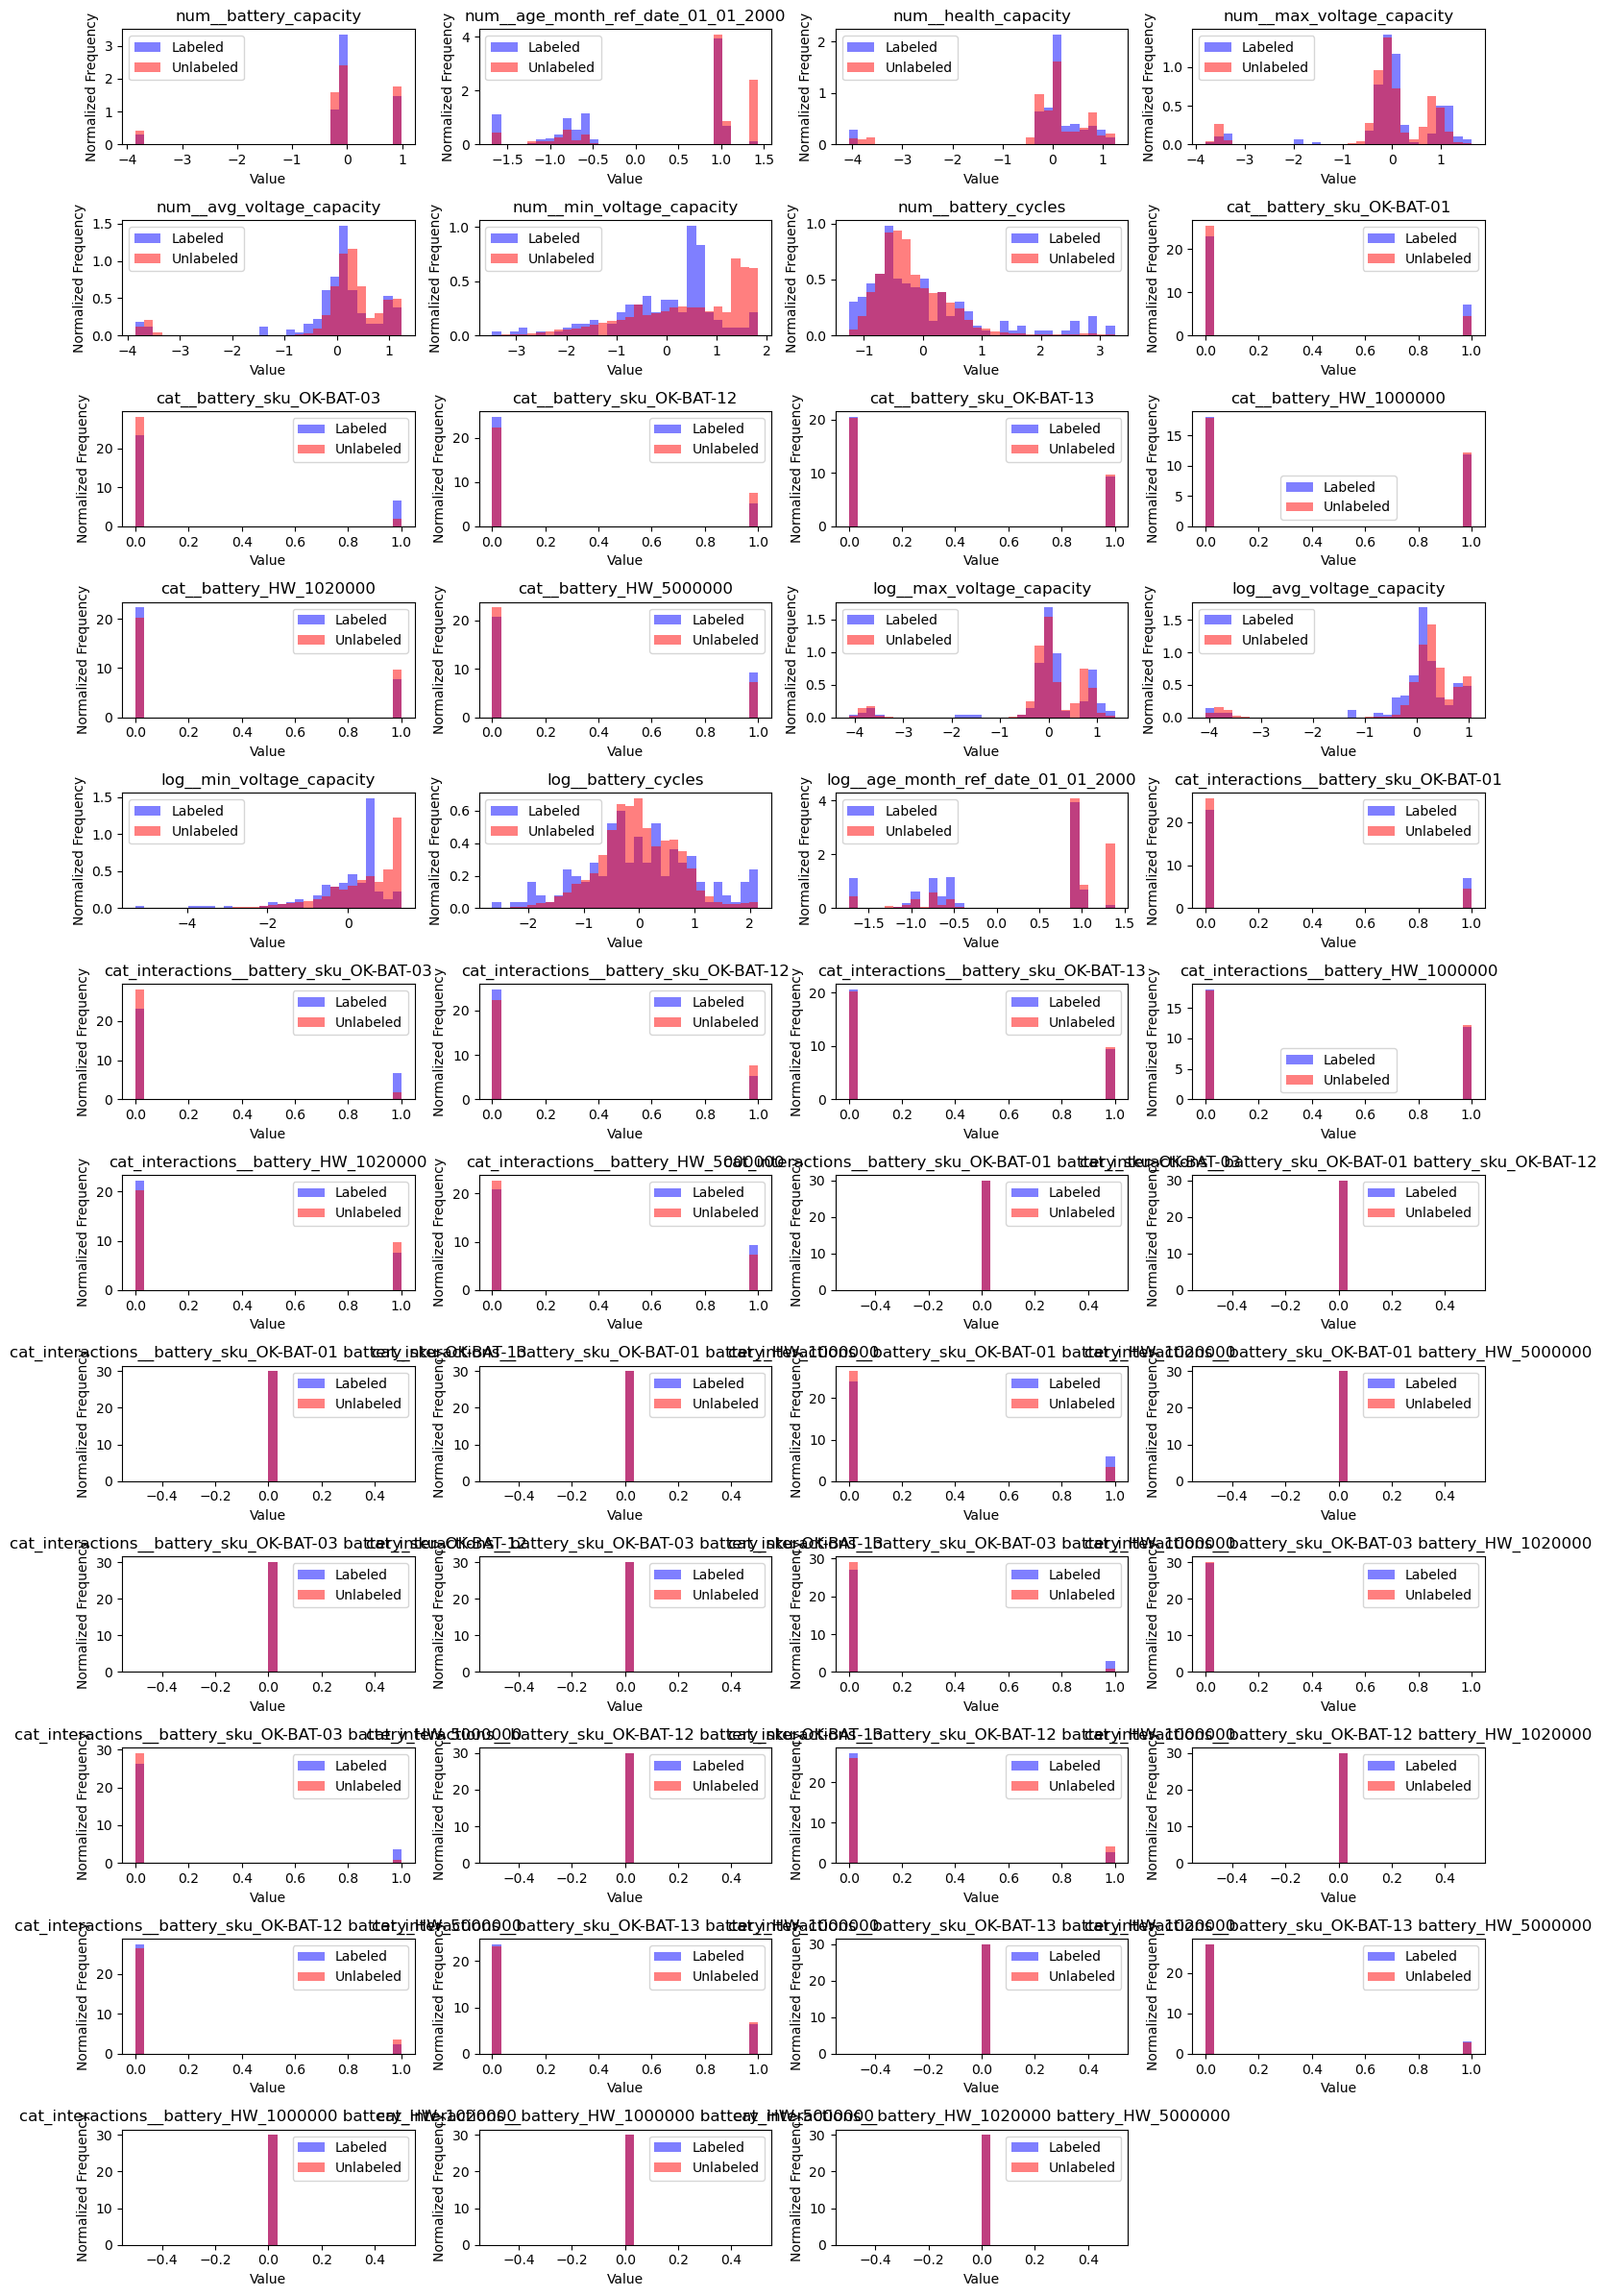

In [138]:
# Apply the preprocessing to X and unlabeled_X
X_preprocessed = preprocessing.fit_transform(X)
unlabeled_X_preprocessed = preprocessing.transform(unlabeled_df)

# Get the feature names after preprocessing
feature_names = preprocessing.get_feature_names_out()

# Plot histograms for each feature in X_preprocessed and unlabeled_X_preprocessed
num_features = X_preprocessed.shape[1]
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_features + num_cols - 1) // num_cols  # Number of rows in the subplot grid

plt.figure(figsize=(15, num_rows * 2))
for i in range(num_features):
    plt.subplot(num_rows, num_cols, i + 1)

    # Normalize histograms
    counts_labeled, bins, _ = plt.hist(X_preprocessed[:, i], bins=30, alpha=0.5, color='blue', density=True, label='Labeled')
    counts_unlabeled, _, _ = plt.hist(unlabeled_X_preprocessed[:, i], bins=bins, alpha=0.5, color='red', density=True, label='Unlabeled')

    plt.title(feature_names[i])
    plt.xlabel('Value')
    plt.ylabel('Normalized Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


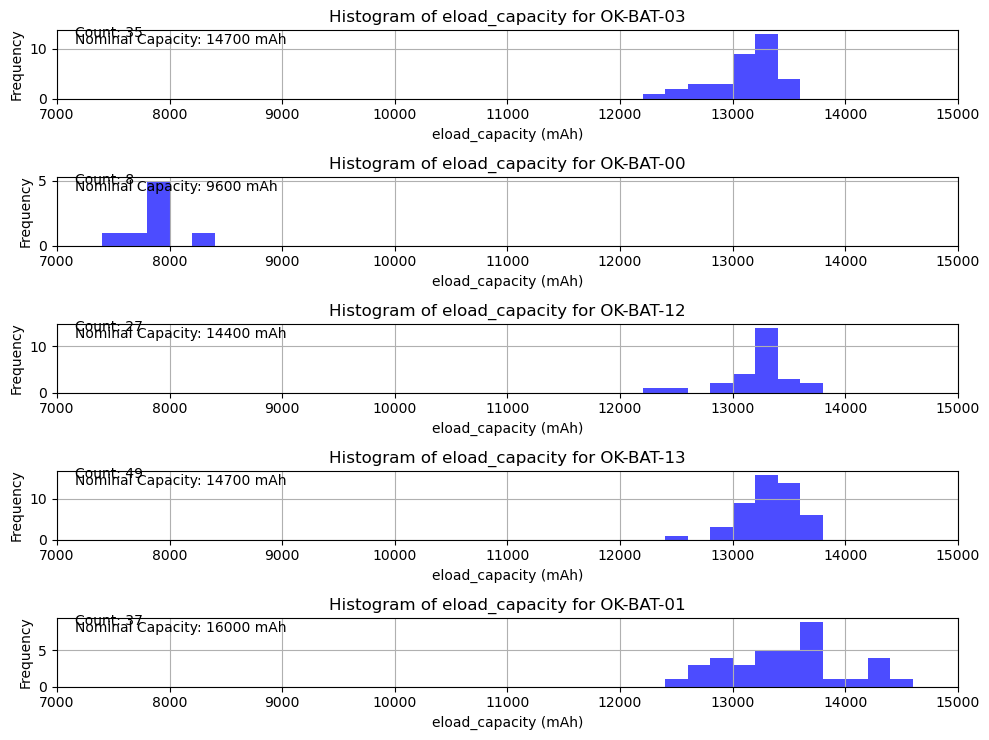

In [139]:
# one histogram per battery_sku showing the eload_capacity
battery_skus = labeled_df['battery_sku'].unique()

# Set up subplots for each battery_sku
fig, axes = plt.subplots(len(battery_skus), 1, figsize=(10, len(battery_skus) * 1.5))

# Find global min and max for consistent x-axis
global_min = labeled_df['eload_capacity'].min()
global_max = labeled_df['eload_capacity'].max()
# Round to nearest 1000 for cleaner limits
x_min = np.floor(global_min / 1000) * 1000
x_max = np.ceil(global_max / 1000) * 1000

# Calculate bins with consistent width
bin_width = 200  # Bin width in mAh
bins = np.arange(x_min, x_max + bin_width, bin_width)

# Create a histogram for each battery_sku
for i, battery_sku in enumerate(battery_skus):
    battery_df = labeled_df[labeled_df['battery_sku'] == battery_sku]
    
    # Plot on the corresponding subplot
    axes[i].hist(battery_df['eload_capacity'], bins=bins, alpha=0.7, color='blue')
    axes[i].set_title(f'Histogram of eload_capacity for {battery_sku}')
    axes[i].set_xlabel('eload_capacity (mAh)')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)
    
    # Set consistent x-axis limits
    axes[i].set_xlim(x_min, x_max)
    
    # Add count and capacity information
    count = len(battery_df)
    capacity = battery_df['battery_capacity'].iloc[0]  # Get battery capacity
    mean_capacity = battery_df['eload_capacity'].mean()
    std_capacity = battery_df['eload_capacity'].std()
    
    axes[i].text(0.02, 0.9, f'Count: {count}', transform=axes[i].transAxes)
    axes[i].text(0.02, 0.8, f'Nominal Capacity: {capacity} mAh', transform=axes[i].transAxes)
 
    
plt.tight_layout()
plt.show()



## Look for Correlations

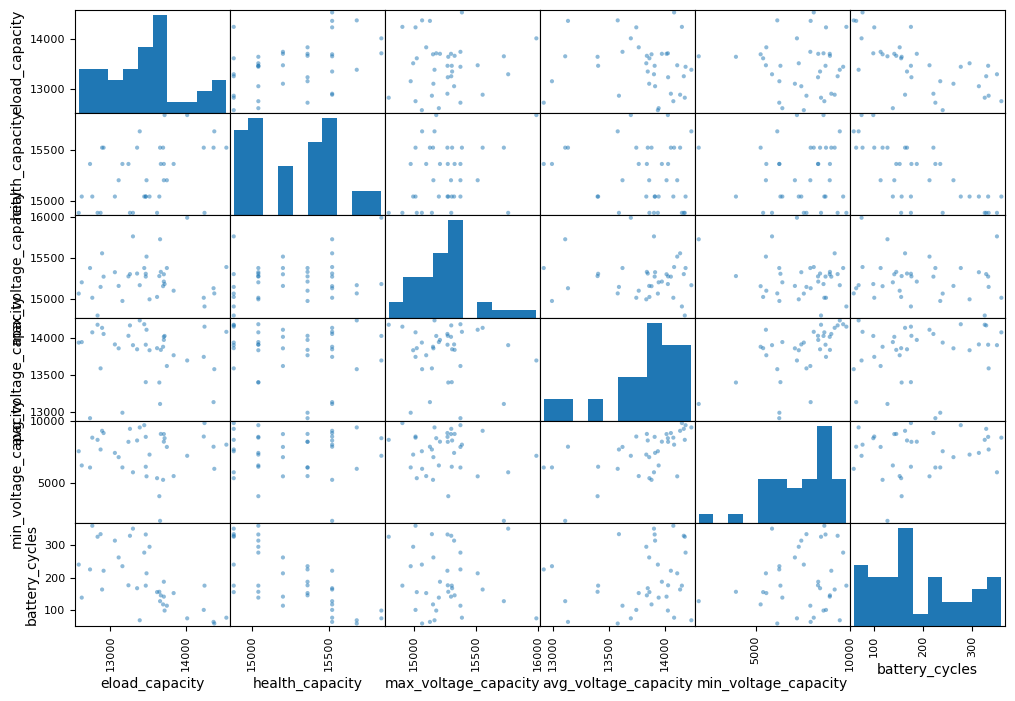

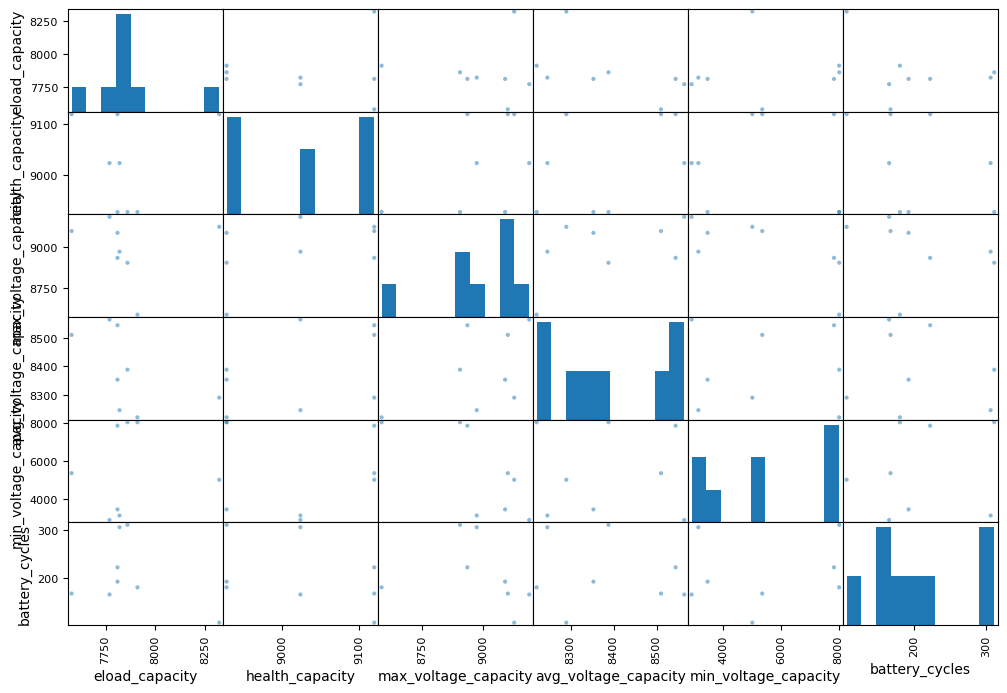

In [140]:
#attributes = ["eload_capacity","age_day","distance_km","idle_drainage_24h", "actual_capacity_mAh", "voltage_soc100", "health_capacity" ]
attributes = ["eload_capacity","health_capacity","max_voltage_capacity","avg_voltage_capacity","min_voltage_capacity","battery_cycles" ]

labeled_df_16Ah = labeled_df[labeled_df["battery_capacity"] == 16000]
scatter_matrix(labeled_df_16Ah[attributes], figsize=(12, 8),)

plt.show()

labeled_df_9_6Ah = labeled_df[labeled_df["battery_capacity"] == 9600]
scatter_matrix(labeled_df_9_6Ah[attributes], figsize=(12, 8),)

plt.show()


## Regression

In [141]:
# make the regression model
reg_model = make_pipeline(
    preprocessing,
    LinearRegression()
)
# Fit the model on the training m
reg_model.fit(X_train,y_train)
# Predict on the test data



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['battery_capacity',
                                                   'age_month_ref_date_01_01_2000',
                                                   'health_capacity',
                                                   'max_voltage_capacity',
                                                   'avg_voltage_capacity',
                                                   'min_voltage_capacity',
                                                   'battery_cycles']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimp...
                                                  Pipeline(steps=[('cat_base',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))])),
                                                                  ('cat_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['battery_sku',
                                                   'battery_HW'])])),
                ('linearregression', LinearRegression())])

c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Linear regression RMSE:  394.3375165046777
Linear regression RMSE:  2.5922402122467614


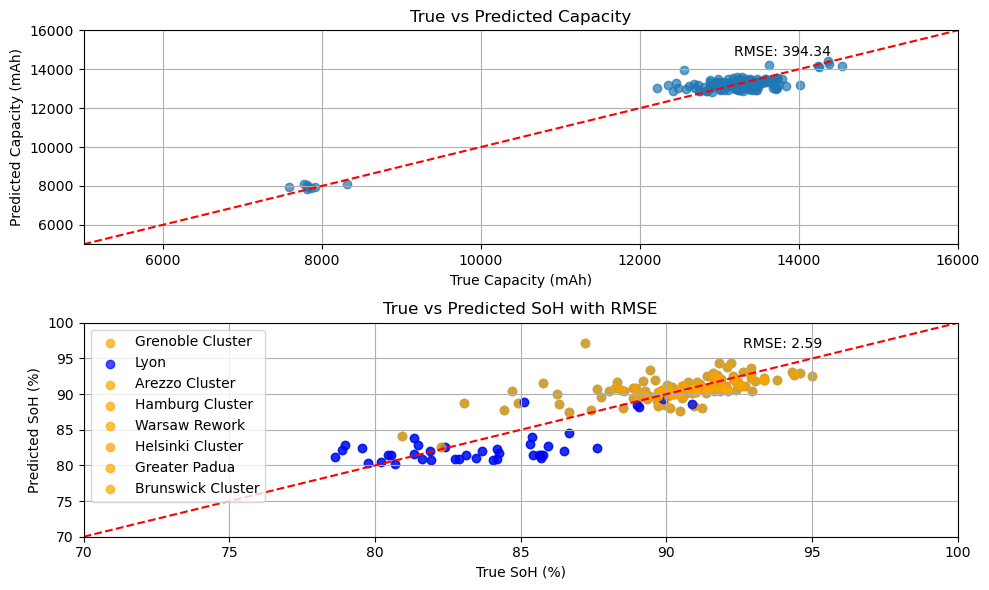

In [142]:
labeled_predictions = reg_model.predict(X)
labeled_df = labeled_df.copy()
labeled_df.loc[:, "predicted_capacity_reg"] = labeled_predictions

# Calculate State of Health (SoH) as a percentage of the original capacity
labeled_df.loc[:, "predicted_soh_reg"] = (labeled_df["predicted_capacity_reg"] / labeled_df["battery_capacity"]) * 100

unlabeled_df=unlabeled_df.copy()
unlabeled_prediction = reg_model.predict(unlabeled_df)
unlabeled_df.loc[:, "predicted_capacity_reg"] = unlabeled_prediction
unlabeled_df.loc[:, "predicted_soh_reg"] = (unlabeled_df["predicted_capacity_reg"] / unlabeled_df["battery_capacity"]) * 100


# plot the predictions
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Capacity plot
axes[0].scatter(y, labeled_df["predicted_capacity_reg"], alpha=0.7)
axes[0].set_xlabel("True Capacity (mAh)")
axes[0].set_ylabel("Predicted Capacity (mAh)")
axes[0].set_title("True vs Predicted Capacity")
axes[0].plot([5000, 16000], [5000, 16000], color='red', linestyle='--')
axes[0].set_xlim(5000, 16000)
axes[0].set_ylim(5000, 16000)
axes[0].grid(True)

lin_rmse_capacity = np.sqrt(mean_squared_error(y, labeled_predictions))
print("Linear regression RMSE: ", lin_rmse_capacity)
axes[0].text(0.8, 0.9, f"RMSE: {lin_rmse_capacity:.2f}", transform=axes[0].transAxes, fontsize=10, color='black', ha='center', va='center')

# SoH plot
axes[1].scatter(labeled_df["eload_soh"], labeled_df["predicted_soh_reg"], alpha=0.7)
axes[1].set_xlabel("True SoH (%)")
axes[1].set_ylabel("Predicted SoH (%)")
axes[1].set_title("True vs Predicted SoH")
axes[1].plot([70, 100], [70, 100], color='red', linestyle='--')
axes[1].set_xlim(70, 100)
axes[1].set_ylim(70, 100)
axes[1].grid(True)

lin_rmse_soh = np.sqrt(mean_squared_error(labeled_df["eload_capacity"]/labeled_df["battery_capacity"]*100, labeled_predictions/labeled_df["battery_capacity"]*100))
print("Linear regression RMSE: ", lin_rmse_soh)
axes[1].text(0.8, 0.9, f"RMSE: {lin_rmse_soh:.2f}", transform=axes[1].transAxes, fontsize=10, color='black', ha='center', va='center')
# Create a dictionary to map city names to colors
city_colors = {'Lyon': 'blue', 'Grenoble': 'green', 'Turin': 'red', 'Lappeenranta': 'purple'}

# Add colors to the scatter plot based on city name
for city in labeled_df['market_name'].unique():
    city_data = labeled_df[labeled_df['market_name'] == city]
    axes[1].scatter(
        city_data["eload_capacity"]/city_data["battery_capacity"]*100, 
        city_data["predicted_soh_reg"], 
        alpha=0.7,
        color=city_colors.get(city, 'orange'),  # Default to orange for any unknown cities
        label=city
    )

# Add a legend
axes[1].legend()
axes[1].set_title("True vs Predicted SoH with RMSE")
plt.tight_layout()
plt.show()

## Elastic Net Regression

### Simple Linear Model

                            OLS Regression Results                            
Dep. Variable:         eload_capacity   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     156.5
Date:                Thu, 03 Jul 2025   Prob (F-statistic):           6.52e-60
Time:                        17:28:16   Log-Likelihood:                -756.79
No. Observations:                 109   AIC:                             1554.
Df Residuals:                      89   BIC:                             1607.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7443.4439     67.767    109.839      0.0

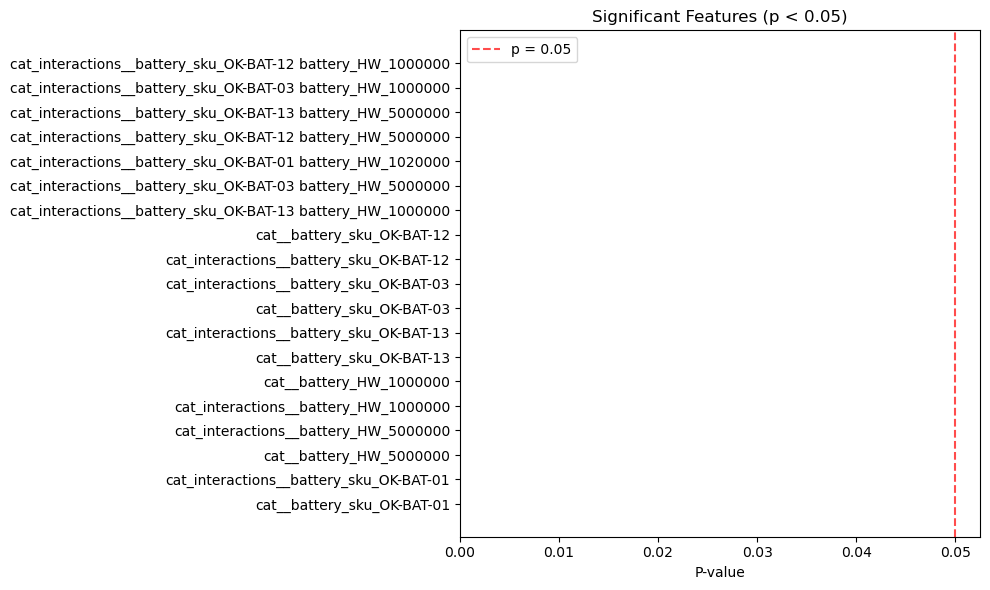

In [143]:
# Preprocess the data
X_processed = preprocessing.fit_transform(X)

# Get the feature names after preprocessing
real_feature_names = preprocessing.get_feature_names_out()

# Split the data into training and test sets
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_processed, y, test_size=0.3, random_state=42)

# Add a constant term for the intercept
X_train_with_const = sm.add_constant(X_train_sm)
X_test_with_const = sm.add_constant(X_test_sm)

# Fit the Ridge model using OLS with L2 penalty
model = sm.OLS(y_train_sm, X_train_with_const)
result = model.fit()

# Print the summary of the model
print(result.summary())

# Debug: Check dimensions
print(f"Number of features after preprocessing: {len(real_feature_names)}")
print(f"Number of parameters in model: {len(result.params)}")
print(f"Number of p-values: {len(result.pvalues)}")

# Create feature names including intercept
# statsmodels adds intercept as first parameter
feature_names_with_intercept = ['intercept'] + list(real_feature_names)

# Ensure we have the right number of feature names
if len(feature_names_with_intercept) != len(result.pvalues):
    print(f"Mismatch detected!")
    print(f"Expected: {len(result.pvalues)} features")
    print(f"Got: {len(feature_names_with_intercept)} feature names")
    
    # Adjust feature names to match the actual number of parameters
    if len(result.pvalues) > len(feature_names_with_intercept):
        # More parameters than feature names - pad with generic names
        missing_count = len(result.pvalues) - len(feature_names_with_intercept)
        feature_names_with_intercept.extend([f'feature_{i}' for i in range(missing_count)])
    else:
        # More feature names than parameters - truncate
        feature_names_with_intercept = feature_names_with_intercept[:len(result.pvalues)]

# Create results DataFrame
result_df = pd.DataFrame({
    'Feature': feature_names_with_intercept,
    'Coefficient': result.params,
    'P-value': result.pvalues,
    'Std Error': result.bse,
    'T-statistic': result.tvalues
})

print("\nAll results:")
print(result_df.sort_values(by='P-value', ascending=True))

# Find significant features (p < 0.05) excluding intercept
significant_features = result_df[
    (result_df['P-value'] < 0.05) & 
    (result_df['Feature'] != 'intercept')
].sort_values(by='P-value', ascending=True)

print(f"\nSignificant features (p < 0.05): {len(significant_features)}")
print(significant_features)

# Plot significant features
if len(significant_features) > 0:
    plt.figure(figsize=(10, max(6, len(significant_features) * 0.3)))
    plt.barh(significant_features['Feature'], significant_features['P-value'])
    plt.xlabel('P-value')
    plt.title('Significant Features (p < 0.05)')
    plt.axvline(x=0.05, color='red', linestyle='--', alpha=0.7, label='p = 0.05')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No significant features found")

# Predict on the test data
y_pred = result.predict(X_test_with_const)

### Residuals

## Lasso Regression

In [144]:

lasso_model_cv = make_pipeline(
    preprocessing,
    LassoCV(
        alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
        cv=5,
        random_state=42,
        max_iter=10000,
        n_jobs=-1
    )
)


# Fit the model on the training data
lasso_model_cv.fit(X_train, y_train)
best_alpha = lasso_model_cv.named_steps['lassocv'].alpha_

lasso_model = make_pipeline(
    preprocessing,
    Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
)

lasso_model.fit(X_train, y_train)


c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 746028.1916209604, tolerance: 7090.143627419356
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31860.04887515586, tolerance: 809.8355241935484
  model = cd_fast.enet_coordinate_descent_gram(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['battery_capacity',
                                                   'age_month_ref_date_01_01_2000',
                                                   'health_capacity',
                                                   'max_voltage_capacity',
                                                   'avg_voltage_capacity',
                                                   'min_voltage_capacity',
                                                   'battery_cycles']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimp...
                                                  Pipeline(steps=[('cat_base',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))])),
                                                                  ('cat_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['battery_sku',
                                                   'battery_HW'])])),
                ('lasso', Lasso(max_iter=10000, random_state=42))])

47 47
Features kept by the Lasso model:
num__battery_capacity: 1052.3333
num__age_month_ref_date_01_01_2000: 185.8642
num__max_voltage_capacity: 31.7950
num__avg_voltage_capacity: -152.0645
num__min_voltage_capacity: 3.4114
num__battery_cycles: 36.8043
cat__battery_sku_OK-BAT-13: -52.9512
cat__battery_HW_1000000: -0.0392
cat__battery_HW_5000000: 89.2051
log__max_voltage_capacity: 86.5899
log__min_voltage_capacity: -15.0202
log__battery_cycles: -95.2153
cat_interactions__battery_sku_OK-BAT-12: 98.0048
cat_interactions__battery_sku_OK-BAT-13: -0.1042
cat_interactions__battery_HW_5000000: 103.1710
cat_interactions__battery_sku_OK-BAT-01 battery_HW_1020000: -1024.6967
cat_interactions__battery_sku_OK-BAT-03 battery_HW_1000000: -155.0574
cat_interactions__battery_sku_OK-BAT-03 battery_HW_5000000: 4.1636
cat_interactions__battery_sku_OK-BAT-12 battery_HW_5000000: 8.1194
cat_interactions__battery_sku_OK-BAT-13 battery_HW_5000000: -233.4584

Features deleted by the Lasso model:
num__health_cap

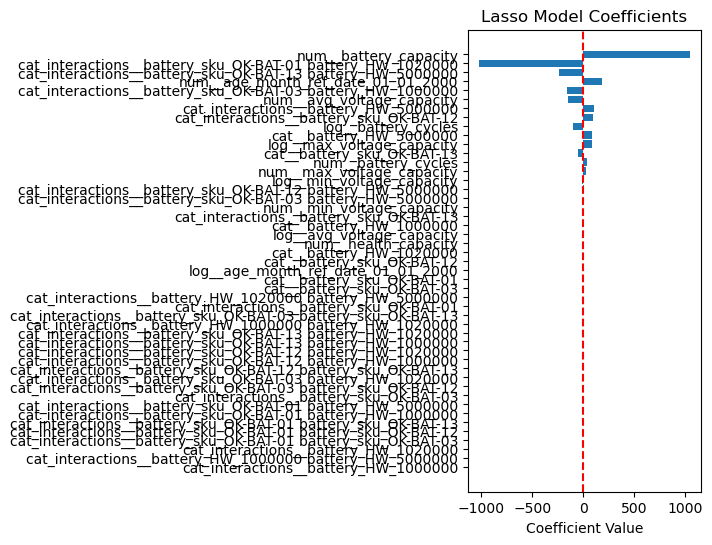

In [145]:
# Extract the feature names and coefficients

feature_names = lasso_model.named_steps['columntransformer'].get_feature_names_out()
# Get the coefficients from the Lasso model
coefficients = lasso_model.named_steps['lasso'].coef_
print(len(feature_names), len(coefficients))

# Print the non-zero coefficients and their corresponding feature names
print("Features kept by the Lasso model:")
kept_features = []
deleted_features = []

for feature, coef in zip(feature_names, coefficients):
    if coef != 0:
        kept_features.append(feature)
        print(f"{feature}: {coef:.4f}")
    else:
        deleted_features.append(feature)

# Print the features that were deleted
print("\nFeatures deleted by the Lasso model:")
for feature in deleted_features:
    print(feature)

# Plot the coefficients
plt.figure(figsize=(3, 6))
plt.xlabel("Coefficient Value")
plt.title("Lasso Model Coefficients")
plt.axvline(0, color='red', linestyle='--')

# Sort coefficients by absolute values for better visualization
sorted_indices = np.argsort(np.abs(coefficients))
plt.barh(range(len(coefficients)), coefficients[sorted_indices], align='center')
plt.yticks(range(len(coefficients)), np.array(feature_names)[sorted_indices])

plt.show()


## Ridge Regression

In [146]:
ridge_model_cv = make_pipeline(
    preprocessing,
    RidgeCV(
        alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
        cv=5,
        scoring='neg_mean_squared_error'
    )
)


# Fit the model on the training data
ridge_model_cv.fit(X_train, y_train)
best_alpha = ridge_model_cv.named_steps['ridgecv'].alpha_
    
ridge_model = make_pipeline(
    preprocessing,
    Ridge(alpha=best_alpha, max_iter=10000, random_state=42)
)

ridge_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['battery_capacity',
                                                   'age_month_ref_date_01_01_2000',
                                                   'health_capacity',
                                                   'max_voltage_capacity',
                                                   'avg_voltage_capacity',
                                                   'min_voltage_capacity',
                                                   'battery_cycles']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimp...
                                                  Pipeline(steps=[('cat_base',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))])),
                                                                  ('cat_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['battery_sku',
                                                   'battery_HW'])])),
                ('ridge', Ridge(alpha=0.5, max_iter=10000, random_state=42))])

Features kept by the Ridge model:
num__battery_capacity: 772.8205
num__age_month_ref_date_01_01_2000: 127.9936
num__health_capacity: 137.5516
num__max_voltage_capacity: 36.9080
num__avg_voltage_capacity: -143.8675
num__min_voltage_capacity: 17.5730
num__battery_cycles: 60.3399
cat__battery_sku_OK-BAT-01: 36.2850
cat__battery_sku_OK-BAT-03: 94.3075
cat__battery_sku_OK-BAT-12: 56.7423
cat__battery_sku_OK-BAT-13: -38.3087
cat__battery_HW_1000000: -108.9791
cat__battery_HW_1020000: -287.4732
cat__battery_HW_5000000: -37.9982
log__max_voltage_capacity: 112.0662
log__avg_voltage_capacity: -12.5974
log__min_voltage_capacity: -21.1964
log__battery_cycles: -88.7553
log__age_month_ref_date_01_01_2000: 118.9424
cat_interactions__battery_sku_OK-BAT-01: 36.2850
cat_interactions__battery_sku_OK-BAT-03: 94.3075
cat_interactions__battery_sku_OK-BAT-12: 56.7423
cat_interactions__battery_sku_OK-BAT-13: -38.3087
cat_interactions__battery_HW_1000000: -108.9791
cat_interactions__battery_HW_1020000: -287.47

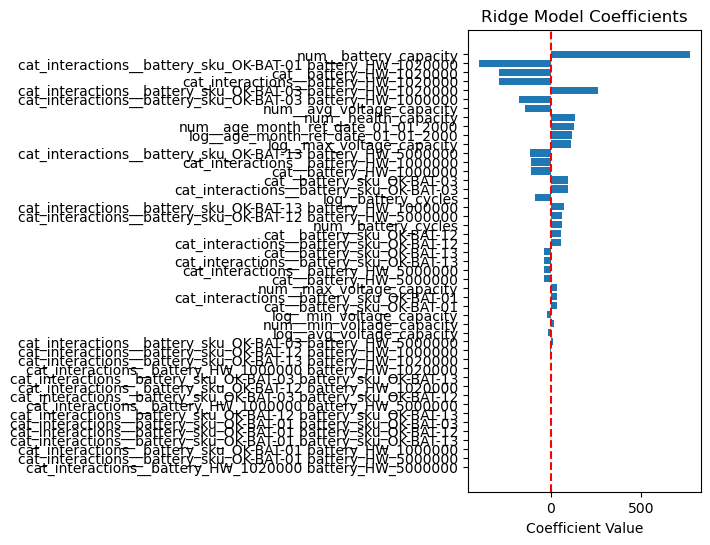

In [147]:
# Plot non zero coefficients
feature_names = preprocessing.get_feature_names_out()
coefficients = ridge_model.named_steps['ridge'].coef_

# Print the non-zero coefficients and their corresponding feature names
print("Features kept by the Ridge model:")
kept_features = []
deleted_features = []
for feature, coef in zip(feature_names, coefficients):
    if coef != 0:
        kept_features.append(feature)
        print(f"{feature}: {coef:.4f}")
    else:
        deleted_features.append(feature)

# plot the coefficients in order of their absolute value
plt.figure(figsize=(3, 6))

plt.xlabel("Coefficient Value")
plt.title("Ridge Model Coefficients")
plt.axvline(0, color='red', linestyle='--')
# Sort coefficients by absolute values for better visualization
sorted_indices = np.argsort(np.abs(coefficients))
plt.barh(range(len(coefficients)), coefficients[sorted_indices], align='center')
plt.yticks(range(len(coefficients)), np.array(feature_names)[sorted_indices])
plt.show()


## Decision Tree

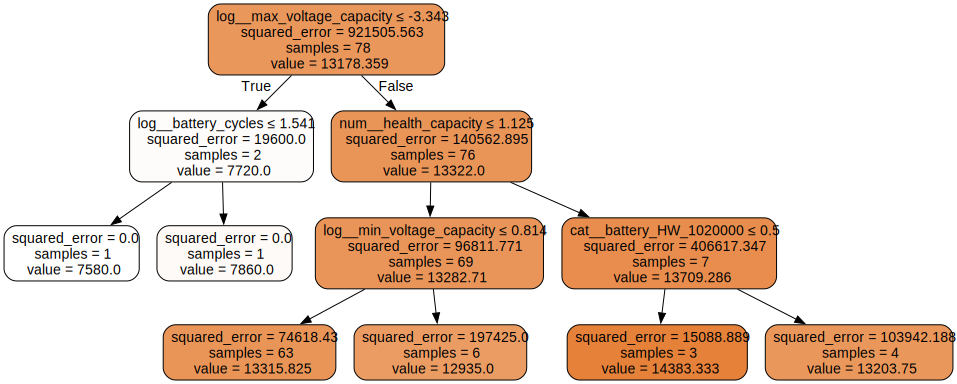

In [148]:
# decision tree regressor
tree_reg = make_pipeline(
    preprocessing,
    DecisionTreeRegressor(random_state=1, max_depth=3)
)


# Fit the model on the training data
tree_reg.fit(X_train, y_train)

#plot the tree regressor 
dot_data = export_graphviz(
    tree_reg.named_steps['decisiontreeregressor'],
    feature_names=preprocessing.get_feature_names_out(),
    rounded=True,
    filled=True,
    special_characters=True
)
Source(dot_data)

c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Decision tree RMSE:  329.4084591549431
Decision tree RMSE:  2.2562344102296774


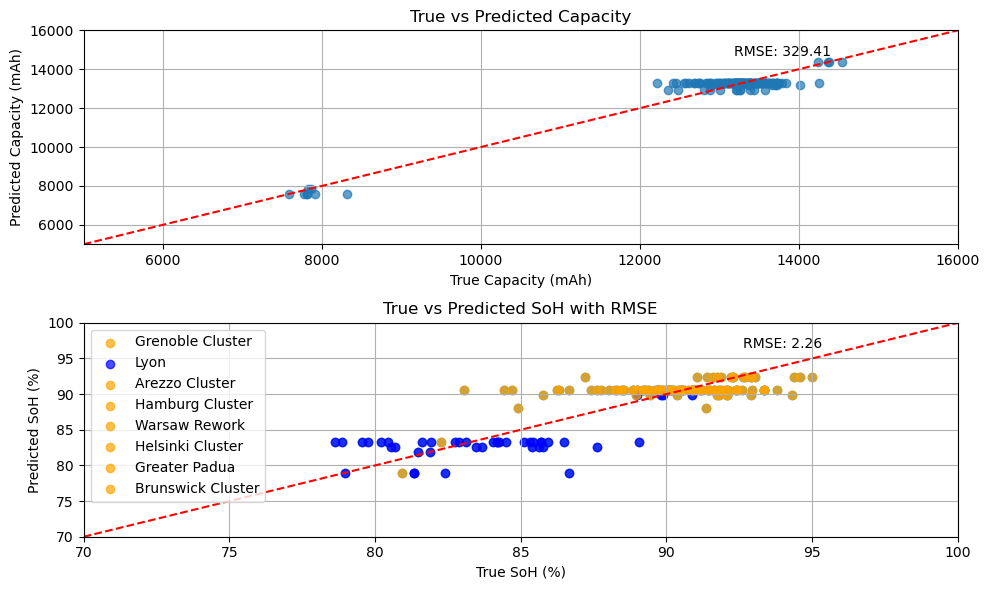

In [149]:

# Predict on both train and test data
labeled_predictions = tree_reg.predict(X)
unlabeled_predictions = tree_reg.predict(unlabeled_df)

# Add predictions to dataframes
labeled_df.loc[:,"predicted_capacity_tree"] = labeled_predictions
unlabeled_df.loc[:,"predicted_capacity_tree"] = unlabeled_predictions

# Calculate SoH for both
labeled_df.loc[:,"predicted_soh_tree"] = (labeled_df["predicted_capacity_tree"] / labeled_df["battery_capacity"]) * 100
unlabeled_df.loc[:,"predicted_soh_tree"] = (unlabeled_df["predicted_capacity_tree"] / unlabeled_df["battery_capacity"]) * 100





# plot the predictions
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Capacity plot
axes[0].scatter(labeled_df["eload_capacity"], labeled_df["predicted_capacity_tree"], alpha=0.7)
axes[0].set_xlabel("True Capacity (mAh)")
axes[0].set_ylabel("Predicted Capacity (mAh)")
axes[0].set_title("True vs Predicted Capacity")
axes[0].plot([5000, 16000], [5000, 16000], color='red', linestyle='--')
axes[0].set_xlim(5000, 16000)
axes[0].set_ylim(5000, 16000)
axes[0].grid(True)

lin_rmse_capacity_tree = np.sqrt(mean_squared_error(labeled_df["eload_capacity"], labeled_predictions))
print("Decision tree RMSE: ", lin_rmse_capacity_tree)
axes[0].text(0.8, 0.9, f"RMSE: {lin_rmse_capacity_tree:.2f}", transform=axes[0].transAxes, fontsize=10, color='black', ha='center', va='center')

# SoH plot
axes[1].scatter(labeled_df["eload_capacity"]/labeled_df["battery_capacity"]*100, labeled_df["predicted_soh_tree"], alpha=0.7)
axes[1].set_xlabel("True SoH (%)")
axes[1].set_ylabel("Predicted SoH (%)")
axes[1].set_title("True vs Predicted SoH")
axes[1].plot([70, 100], [70, 100], color='red', linestyle='--')
axes[1].set_xlim(70, 100)
axes[1].set_ylim(70, 100)
axes[1].grid(True)

lin_rmse_soh_tree = np.sqrt(mean_squared_error(labeled_df["eload_capacity"]/labeled_df["battery_capacity"]*100, labeled_df["predicted_soh_tree"]))
print("Decision tree RMSE: ", lin_rmse_soh_tree)
axes[1].text(0.8, 0.9, f"RMSE: {lin_rmse_soh_tree:.2f}", transform=axes[1].transAxes, fontsize=10, color='black', ha='center', va='center')
# Create a dictionary to map city names to colors
city_colors = {'Lyon': 'blue', 'Grenoble': 'green', 'Turin': 'red', 'Lappeenranta': 'purple'}

# Add colors to the scatter plot based on city name
for city in labeled_df['market_name'].unique():
    city_data = labeled_df[labeled_df['market_name'] == city]
    axes[1].scatter(
        city_data["eload_capacity"]/city_data["battery_capacity"]*100, 
        city_data["predicted_soh_tree"], 
        alpha=0.7,
        color=city_colors.get(city, 'orange'),  # Default to orange for any unknown cities
        label=city
    )

# Add a legend
axes[1].legend()
axes[1].set_title("True vs Predicted SoH with RMSE")
plt.tight_layout()
plt.show()





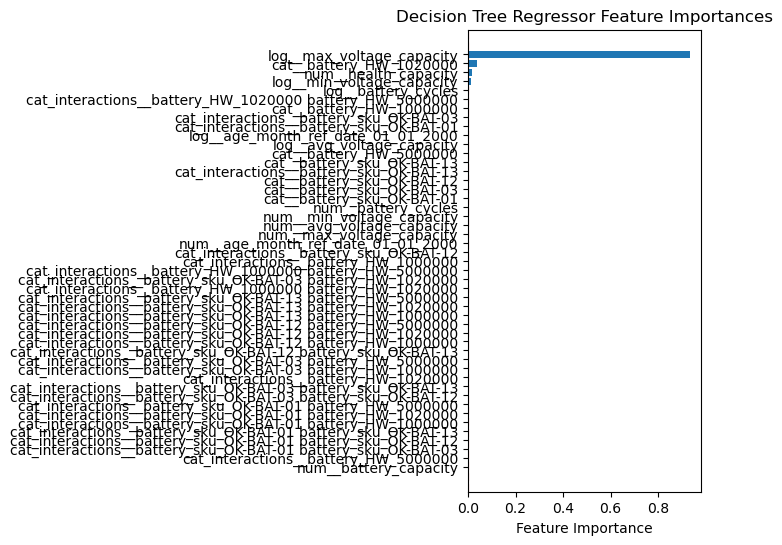

In [150]:
#feature importance
importances = tree_reg.named_steps['decisiontreeregressor'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(3, 6))
plt.xlabel("Feature Importance")
plt.title("Decision Tree Regressor Feature Importances")
plt.axvline(0, color='red', linestyle='--')

# Sort importances by their values for better visualization
sorted_indices = np.argsort(importances)
plt.barh(range(len(importances)), importances[sorted_indices], align='center')
plt.yticks(range(len(importances)), np.array(feature_names)[sorted_indices])

plt.show()


### Cross Validation

In [151]:
# Define the parameter grid for cross-validation
param_grid = {
    'decisiontreeregressor__max_depth': [2, 3, 4, 10],
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__min_samples_leaf': [1, 2, 4],
    'decisiontreeregressor__max_leaf_nodes': [None, 5, 10, 15]
}

# Initialize the model with preprocessing pipeline
tree_model = make_pipeline(
    preprocessing,
    DecisionTreeRegressor(random_state=42)  # Use a random state for reproducibility
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=tree_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Use all available cores
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best cross-validation RMSE:", np.sqrt(-grid_search.best_score_))


Best Parameters: {'decisiontreeregressor__max_depth': 4, 'decisiontreeregressor__max_leaf_nodes': None, 'decisiontreeregressor__min_samples_leaf': 2, 'decisiontreeregressor__min_samples_split': 2}
Best cross-validation RMSE: 938.5062802456864


c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## Random Forest

c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 200}
Best cross-validation RMSE: 935.8664393200089


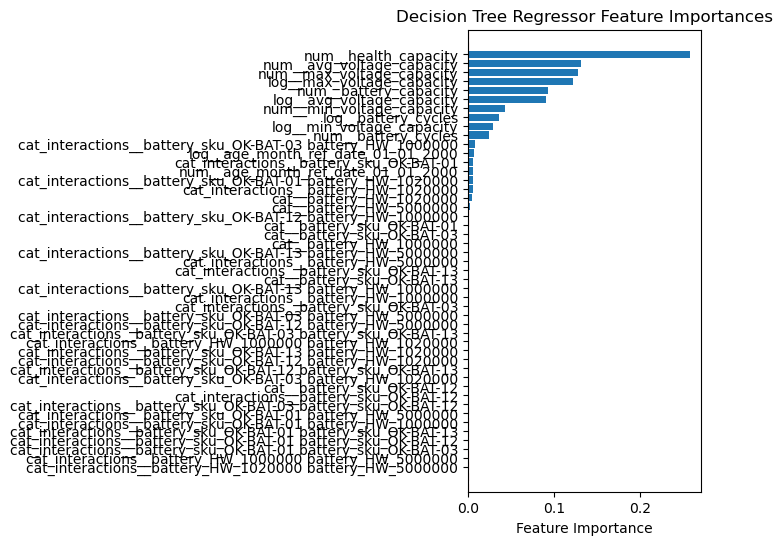

In [152]:
# Cross-validation for Random Forest
# Define the parameter grid
param_grid = {
    'randomforestregressor__n_estimators': [100, 200, 300],
    'randomforestregressor__max_depth': [None, 3, 5, 10, 15],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4]
}

# Initialize the model with preprocessing
rf_model = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Use all available cores for faster processing
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Create Random Forest model with best parameters
best_rf_model = grid_search.best_estimator_
print("Best cross-validation RMSE:", np.sqrt(-grid_search.best_score_))
rf_reg = best_rf_model

# Print the feature importances
importances = best_rf_model.named_steps['randomforestregressor'].feature_importances_
indices = np.argsort(importances)[::-1]


# Plot the feature importances
plt.figure(figsize=(3, 6))
plt.xlabel("Feature Importance")
plt.title("Decision Tree Regressor Feature Importances")
plt.axvline(0, color='red', linestyle='--')

# Sort importances by their values for better visualization
sorted_indices = np.argsort(importances)
plt.barh(range(len(importances)), importances[sorted_indices], align='center')
plt.yticks(range(len(importances)), np.array(feature_names)[sorted_indices])

plt.show()


## Extra Tree 

In [153]:
# Define the Random Forest regression model with preprocessing
ext_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42, min_samples_split=10)
)

# Fit the model on the training data
ext_reg.fit(X_train, y_train)

# Plot one of the trees in the Random Forest
tree_index = 0  # You can choose any tree index to visualize
dot_data = export_graphviz(
    ext_reg.named_steps['randomforestregressor'].estimators_[tree_index],
    feature_names=preprocessing.get_feature_names_out(),
    rounded=True,
    filled=True,
    special_characters=True
)
Source(dot_data)

# Predict on both train and test data
labeled_predictions = ext_reg.predict(X)
unlabeled_predictions = ext_reg.predict(unlabeled_df)

# Add predictions to dataframes
labeled_df = labeled_df.copy()
labeled_df.loc[:, "predicted_capacity_rf"] = labeled_predictions
unlabeled_df = unlabeled_df.copy()
unlabeled_df.loc[:, "predicted_capacity_rf"] = unlabeled_predictions

# Calculate SoH for both
labeled_df.loc[:, "predicted_soh_rf"] = (labeled_df["predicted_capacity_rf"] / labeled_df["battery_capacity"]) * 100
unlabeled_df.loc[:, "predicted_soh_rf"] = (unlabeled_df["predicted_capacity_rf"] / unlabeled_df["battery_capacity"]) * 100

c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Corentin Triboulet\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Adaptative Boosting 

In [154]:
adaboost_reg = make_pipeline(
    preprocessing,
    AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=3),
        n_estimators=100,
        random_state=42
    )
)

# Fit the model on the training data
adaboost_reg.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['battery_capacity',
                                                   'age_month_ref_date_01_01_2000',
                                                   'health_capacity',
                                                   'max_voltage_capacity',
                                                   'avg_voltage_capacity',
                                                   'min_voltage_capacity',
                                                   'battery_cycles']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimp...
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))])),
                                                                  ('cat_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['battery_sku',
                                                   'battery_HW'])])),
                ('adaboostregressor',
                 AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),
                                   n_estimators=100, random_state=42))])

In [155]:
random_grid = {
    'adaboostregressor__n_estimators': [10, 50, 100, 200],
    'adaboostregressor__learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Perform HalvingRandomSearchCV
halving_search = HalvingRandomSearchCV(
    estimator=adaboost_reg,
    param_distributions=random_grid,  # Corrected parameter name
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores for faster processing
    factor=3,  # Halving factor (must be an integer)
    min_resources='smallest',  # Corrected to 'smallest'
    aggressive_elimination=True,  # Optional: Eliminate poor candidates early
    random_state=42  # Ensure reproducibility
)

# Fit the model
halving_search.fit(X_train, y_train)

# Get the best parameters
best_params = halving_search.best_params_
print("Best Parameters:", best_params)
print("Best cross-validation RMSE:", np.sqrt(-halving_search.best_score_))

Best Parameters: {'adaboostregressor__n_estimators': 10, 'adaboostregressor__learning_rate': 0.01}
Best cross-validation RMSE: 1073.400557771199


## Gradient Boosting

In [156]:
gboost_reg = make_pipeline(
    preprocessing,
    GradientBoostingRegressor(
    )
)

# Fit the model on the training data
gboost_reg.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['battery_capacity',
                                                   'age_month_ref_date_01_01_2000',
                                                   'health_capacity',
                                                   'max_voltage_capacity',
                                                   'avg_voltage_capacity',
                                                   'min_voltage_capacity',
                                                   'battery_cycles']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimp...
                                                  Pipeline(steps=[('cat_base',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehotencoder',
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))])),
                                                                  ('cat_interactions',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['battery_sku',
                                                   'battery_HW'])])),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [157]:
# cross-validation for gradient boosting
param_grid = {
    'gradientboostingregressor__n_estimators': [5, 10, 50],
    'gradientboostingregressor__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5, 1],
    'gradientboostingregressor__max_depth': [2, 3, 5, 7]
}

# Initialize GridSearchCV   
grid_search = GridSearchCV(
    estimator=gboost_reg, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Use all available cores for faster processing
)
# Fit the model
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best cross-validation RMSE:", np.sqrt(-grid_search.best_score_))
gboost_reg = grid_search.best_estimator_

Best Parameters: {'gradientboostingregressor__learning_rate': 0.2, 'gradientboostingregressor__max_depth': 2, 'gradientboostingregressor__n_estimators': 10}
Best cross-validation RMSE: 944.8413371971535


## One-time prediction

In [158]:
#Print the predicted capacity and SoH for one selected battery
vendor_battery_id = "0015060200000C48"  # Replace with the actual vendor_battery_id you want to check
battery_data = unlabeled_df[unlabeled_df["vendor_battery_id"] == vendor_battery_id]

if not battery_data.empty:
    # Create a table to display the results
    results = {
        'Model': ['Linear Regression', 'Decision Tree', 'Lasso'],
        'Predicted Capacity (mAh)': [
            round(battery_data["predicted_capacity_reg"].values[0]),
            round(battery_data["predicted_capacity_tree"].values[0]),
            round(battery_data["predicted_capacity_lasso"].values[0])
        ],
        'Predicted SoH (%)': [
            round(battery_data["predicted_soh_reg"].values[0], 2),
            round(battery_data["predicted_soh_tree"].values[0], 2),
            round(battery_data["predicted_soh_lasso"].values[0], 2)
        ]
    }
    
    results_df = pd.DataFrame(results)
    print(f"Predictions for battery {vendor_battery_id}:")
    display(results_df)
    
   
else:
    print(f"Battery with ID {vendor_battery_id} not found in the test dataset.")

Battery with ID 0015060200000C48 not found in the test dataset.


## Models Comparison

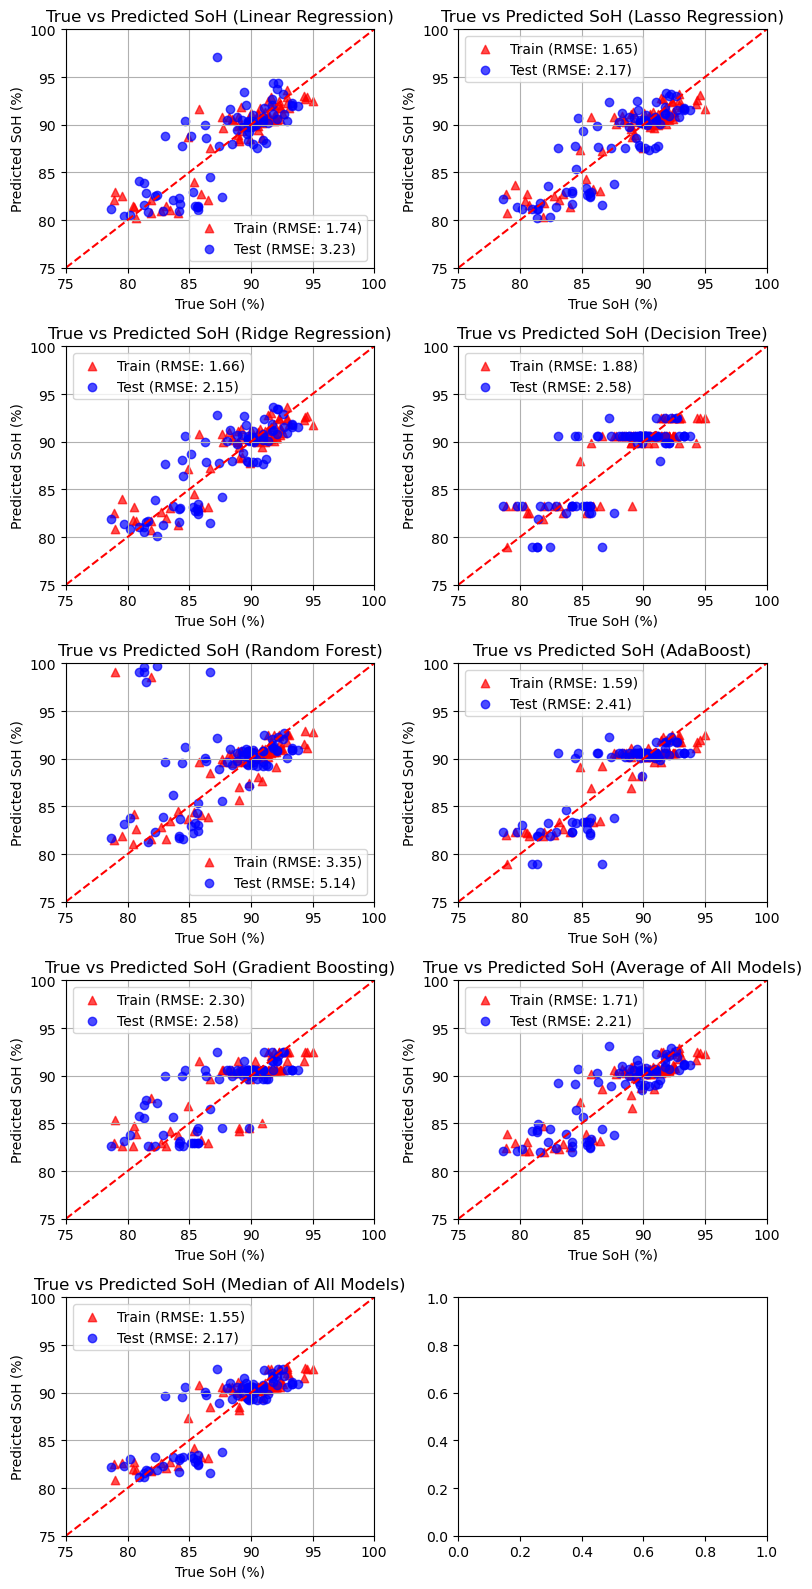

In [159]:
# Define a function to calculate RMSE
def calculate_rmse(y_true, y_pred, battery_capacity):
    return np.sqrt(mean_squared_error((y_true / battery_capacity)* 100, (y_pred / battery_capacity) * 100))

# Define a function to plot predictions
def plot_predictions(ax, y_train, y_test, y_pred_train, y_pred_test, battery_capacity_train, battery_capacity_test, title, rmse_train, rmse_test, low_lim, up_lim):
    ax.scatter(y_train / battery_capacity_train * 100, y_pred_train / battery_capacity_train * 100, alpha=0.7, color='red', marker='^', label=f'Train (RMSE: {rmse_train:.2f})')
    ax.scatter(y_test / battery_capacity_test * 100, y_pred_test / battery_capacity_test * 100, alpha=0.7, color='blue', marker='o', label=f'Test (RMSE: {rmse_test:.2f})')
    ax.set_xlabel("True SoH (%)")
    ax.set_ylabel("Predicted SoH (%)")
    ax.set_title(title)
    ax.plot([low_lim, up_lim], [low_lim, up_lim], color='red', linestyle='--')
    ax.set_xlim(low_lim, up_lim)
    ax.set_ylim(low_lim, up_lim)
    ax.grid(True)
    ax.legend()

# Extract battery capacities
battery_capacity_test = X_test["battery_capacity"].values
battery_capacity_train = X_train["battery_capacity"].values

# Define models and their names
models = [
    ("Linear Regression", reg_model),
    ("Lasso Regression", lasso_model),
    ("Ridge Regression", ridge_model),
    ("Decision Tree", tree_reg),
    ("Random Forest", rf_reg),
    ("AdaBoost", adaboost_reg),
    ("Gradient Boosting", gboost_reg)
]

# Calculate RMSE for each model
rmse_results = {}
for name, model in models:
    rmse_results[name] = {
        "train": calculate_rmse(y_train, model.predict(X_train), battery_capacity_train),
        "test": calculate_rmse(y_test, model.predict(X_test), battery_capacity_test)
    }

# Calculate ensemble predictions
predictions_train = np.column_stack([model.predict(X_train) for _, model in models])
predictions_test = np.column_stack([model.predict(X_test) for _, model in models])

rmse_results["Average"] = {
    "train": calculate_rmse(y_train, np.mean(predictions_train, axis=1), battery_capacity_train),
    "test": calculate_rmse(y_test, np.mean(predictions_test, axis=1), battery_capacity_test)
}

rmse_results["Median"] = {
    "train": calculate_rmse(y_train, np.median(predictions_train, axis=1), battery_capacity_train),
    "test": calculate_rmse(y_test, np.median(predictions_test, axis=1), battery_capacity_test)
}

# Plotting limits
low_lim, up_lim = 75, 100

# Create a figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(8, 16))
axes = axes.flatten()

# Plot predictions for each model
for i, (name, model) in enumerate(models):
    plot_predictions(axes[i], y_train, y_test, model.predict(X_train), model.predict(X_test), battery_capacity_train, battery_capacity_test, f"True vs Predicted SoH ({name})", rmse_results[name]["train"], rmse_results[name]["test"], low_lim, up_lim)

# Plot ensemble predictions
plot_predictions(axes[len(models)], y_train, y_test, np.mean(predictions_train, axis=1), np.mean(predictions_test, axis=1), battery_capacity_train, battery_capacity_test, "True vs Predicted SoH (Average of All Models)", rmse_results["Average"]["train"], rmse_results["Average"]["test"], low_lim, up_lim)
plot_predictions(axes[len(models)+1], y_train, y_test, np.median(predictions_train, axis=1), np.median(predictions_test, axis=1), battery_capacity_train, battery_capacity_test, "True vs Predicted SoH (Median of All Models)", rmse_results["Median"]["train"], rmse_results["Median"]["test"], low_lim, up_lim)

plt.tight_layout()
plt.show()


### Learnings Curves

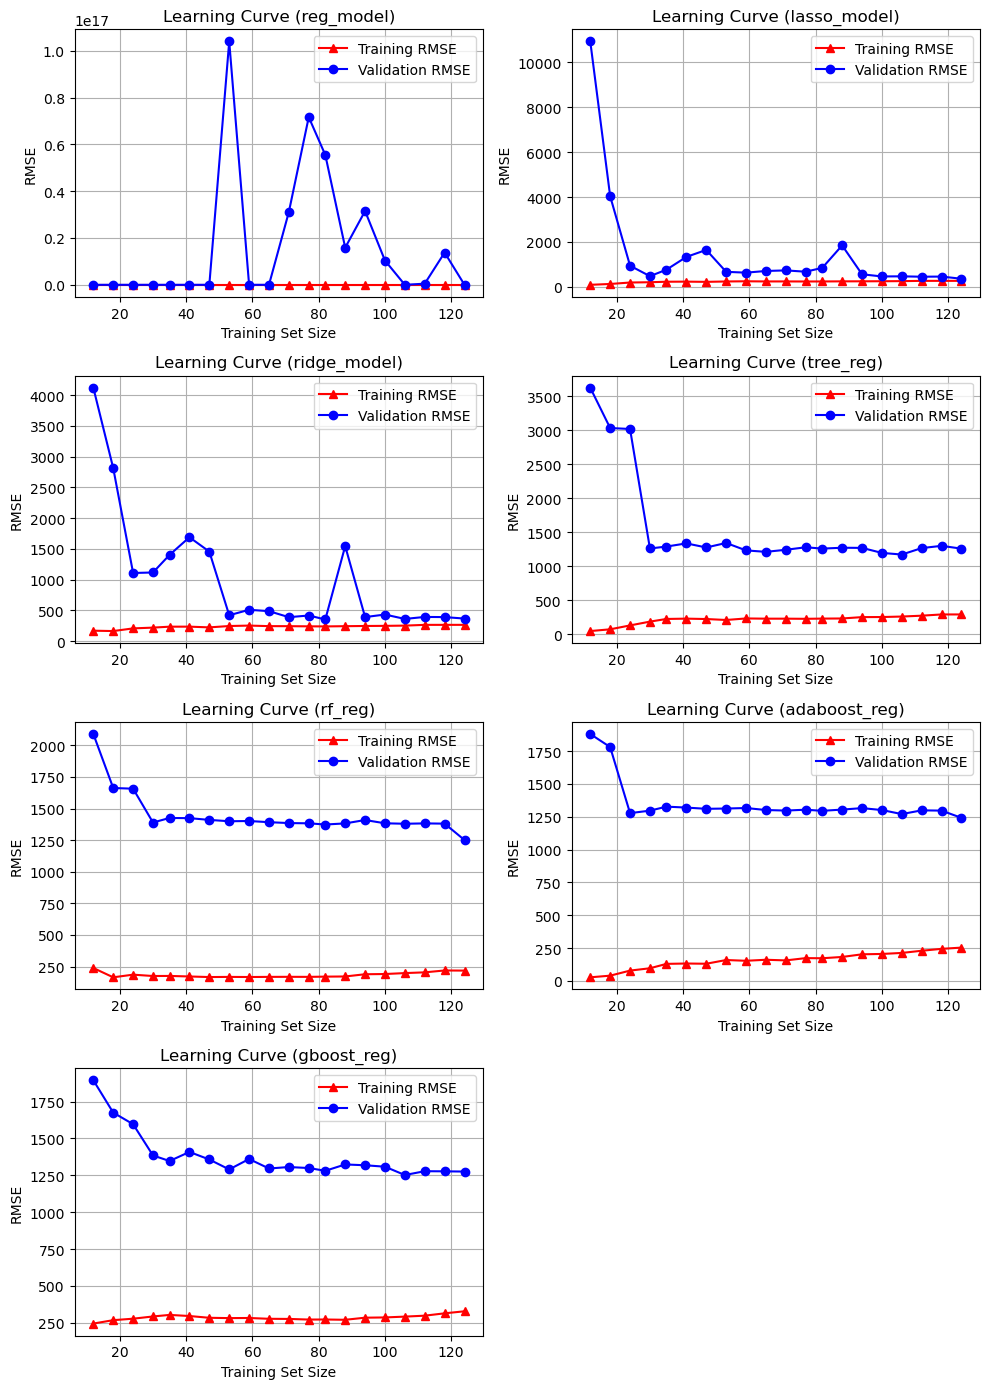

In [160]:
# Function to plot learning curves
def plot_learning_curve(model, X, y, ax, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 20), n_jobs=-1
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    test_rmse = np.sqrt(-test_scores.mean(axis=1))

    ax.plot(train_sizes, train_rmse, color='red', marker='^', label='Training RMSE')
    ax.plot(train_sizes, test_rmse, color='blue', marker='o', label='Validation RMSE')
    ax.set_xlabel("Training Set Size")
    ax.set_ylabel("RMSE")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# Create a figure with subplots
fig, axes = plt.subplots(4, 2, figsize=(10, 14))
axes = axes.flatten()  # Flatten the 3x2 array to make indexing easier
models = [
    ("reg_model", reg_model),
    ("lasso_model", lasso_model),
    ("ridge_model", ridge_model),
    ("tree_reg", tree_reg),
    ("rf_reg", rf_reg),
    ("adaboost_reg", adaboost_reg),
    ("gboost_reg", gboost_reg)
]

for i, (model_name, model) in enumerate(models):
    plot_learning_curve(model, X, y, axes[i], f"Learning Curve ({model_name})")

# Remove empty subplots
for i in range(len(models), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

